<a href="https://colab.research.google.com/github/JulienGremillot/codelab_machine_learning/blob/main/Codelab_Classification_d'images_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

On récupère le jeu de données "[Hotdog NotHotdog](https://www.kaggle.com/yashvrdnjain/hotdognothotdog)", disponible sur Kaggle ou sur mon drive à l'URL précisée dans le code.

Pour patienter, vous pouvez regarder la [vidéo d'inspiration](https://www.youtube.com/watch?v=pqTntG1RXSY).

In [1]:
import requests
from tqdm import tqdm
URL = "https://drive.google.com/uc?export=download"
id = "1pPl16WK_txBH-STO5v9sTbP6xfuxqbin"

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        with tqdm(unit='B', unit_scale=True, unit_divisor=1024) as bar:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk:  # filter out keep-alive new chunks
                    f.write(chunk)
                    bar.update(CHUNK_SIZE)

session = requests.Session()
response = session.get(URL, params = { 'id' : id }, stream = True)
token = get_confirm_token(response)

if token:
    params = { 'id' : id, 'confirm' : token }
    response = session.get(URL, params = params, stream = True)

save_response_content(response, "hotdog-nothotdog.zip")    

166MB [00:02, 84.2MB/s]


On décompresse le fichier ZIP

In [2]:
dataset_dir = "hotdog-nothotdog"
width, height = 224, 224
import zipfile
with zipfile.ZipFile('hotdog-nothotdog.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

On affiche quelques images du dataset

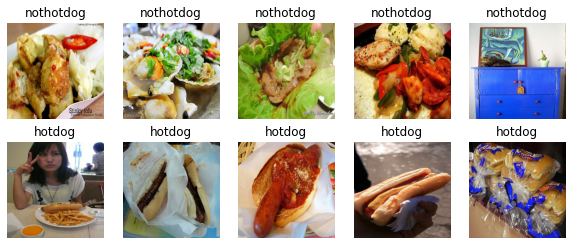

In [3]:
# Lecture des images du dataset
import os
from PIL import Image
import matplotlib.pyplot as plt

train_dir = os.path.join(dataset_dir, 'train')
plt.figure(figsize=(10,4))
i = 1
for sub_dir in os.listdir(train_dir):
    sub_dir_images = os.listdir(os.path.join(train_dir, sub_dir))
    j = 0
    for sub_dir_image in sub_dir_images:
        if i <= 10 and j < 5:
            image = os.path.join(train_dir, sub_dir, sub_dir_image)
            img = Image.open(image) 
            img_resized = img.resize((width, height))
            plt.subplot(2, 5, i)
            plt.axis('off')
            plt.title(sub_dir)
            plt.imshow(img_resized)
            i = i + 1
            j = j + 1
plt.show()

On réalise un split 80% / 20% pour les jeux d'entrainement et de validation.

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory
batch_size = 32
train_ds = image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)
val_ds = image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Found 3000 files belonging to 2 classes.
Using 600 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['hotdog', 'nothotdog']


L'objet train_ds permet de découper le jeu de données en batchs de 32 images.

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [13]:
img_shape = image_batch[0].shape
num_classes = len(class_names)
print("Dimensions de l'image :", img_shape)
print("Nombre de classes de sortie :", num_classes)

Dimensions de l'image : (224, 224, 3)
Nombre de classes de sortie : 2


In [14]:
import tensorflow as tf

nb_epochs = 5
print("Nombre d'epochs pour l'entrainement :", nb_epochs)

model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(height, width, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

Nombre d'epochs pour l'entrainement : 5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 flatten_3 (Flatten)         (None, 150528)            0         
                                                                 
 dense_3 (Dense)             (None, 128)               19267712  
                                                                 
 dense_4 (Dense)             (None, 2)                 258       
                                                                 
Total params: 19,267,970
Trainable params: 19,267,970
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=nb_epochs
)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


75/75 [==============================] - 16s 211ms/step - loss: 4200.2627 - accuracy: 0.5387 - val_loss: 378.2618 - val_accuracy: 0.5983
Epoch 2/5
75/75 [==============================] - 15s 198ms/step - loss: 423.7158 - accuracy: 0.6050 - val_loss: 327.4294 - val_accuracy: 0.6150
Epoch 3/5
75/75 [==============================] - 11s 145ms/step - loss: 511.4974 - accuracy: 0.5987 - val_loss: 479.0313 - val_accuracy: 0.5283
Epoch 4/5
75/75 [==============================] - 11s 148ms/step - loss: 383.8944 - accuracy: 0.6054 - val_loss: 173.9381 - val_accuracy: 0.5683
Epoch 5/5
75/75 [==============================] - 12s 157ms/step - loss: 240.9503 - accuracy: 0.6558 - val_loss: 649.1401 - val_accuracy: 0.4900


In [17]:
import matplotlib.pyplot as plt

def show_perfs(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

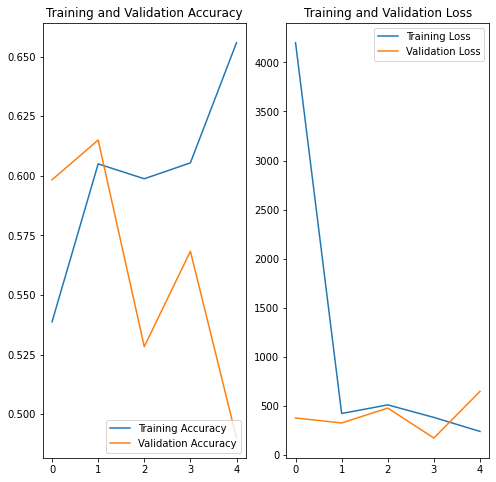

In [33]:
show_perfs(history, nb_epochs)

In [20]:
import numpy as np

def get_prediction(img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)  # batch d'1 seule image
  prediction = model.predict(img_batch)
  # print(prediction)  # vecteur des probabilités par classe
  top_indice = prediction[0].argsort()[-1:][0]
  result = class_names[top_indice]
  return(result)

def test_model(model):
  test_dir = os.path.join(dataset_dir, 'test')
  plt.figure(figsize=(16, 8))
  i = 1
  j = 0
  oks = 0
  kos = 0
  for sub_dir in os.listdir(test_dir):
      hotdog_images = os.listdir(os.path.join(test_dir, sub_dir))
      for hotdog_image in hotdog_images:
          if i <= 5:
              img_path = os.path.join(test_dir, sub_dir, hotdog_image)
              img = Image.open(img_path)
              img_resized = img.resize((width, height))
              plt.subplot(2, 5, i + j * 5)
              plt.axis('off')
              prediction = get_prediction(img_resized)
              title = sub_dir + '\n> ' + prediction
              if sub_dir == prediction:
                title += " OK"
                oks += 1
              else:
                title += " KO"
                kos += 1
              plt.title(title)
              plt.imshow(img_resized)
              i += 1
      i = 1
      j += 1
  plt.show()
  print("\nOKs :", oks, "KOs :", kos, 
        "Pourcentage OK :", round(oks * 100 / (oks + kos)), "%")

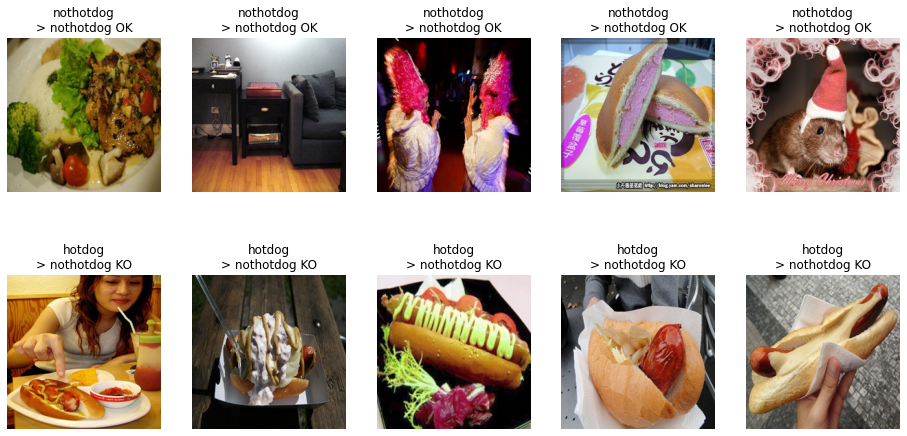


OKs : 5 KOs : 5 Pourcentage OK : 50 %


In [34]:
test_model(model)

On est dans les 60% de réussite, ce qui est bien mais pas top.
Il nous faut plus de données !

In [8]:
data_augmentation = tf.keras.models.Sequential([
  tf.keras.layers.RandomFlip("horizontal", input_shape=(height, width, 3)),
  tf.keras.layers.RandomRotation(factor=0.4, fill_mode="wrap"),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="wrap"),
  tf.keras.layers.RandomContrast(factor=0.2)
])

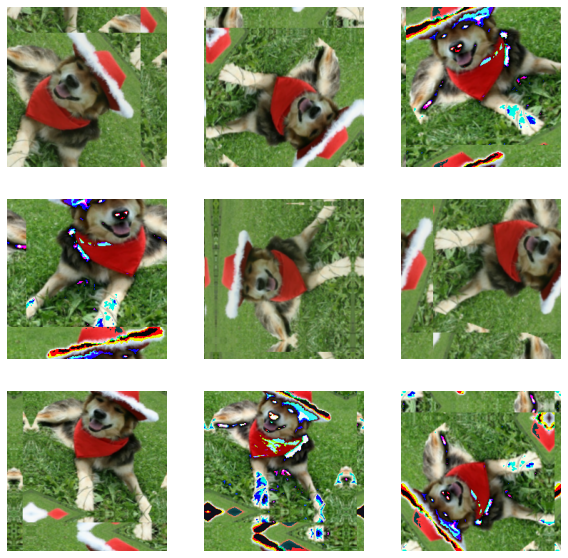

In [36]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [38]:
model = tf.keras.models.Sequential([           
  tf.keras.layers.Input(shape=(height, width, 3)),
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 flatten_4 (Flatten)         (None, 150528)            0         
                                                                 
 dense_8 (Dense)             (None, 128)               19267712  
                                                                 
 dense_9 (Dense)             (None, 2)                 258       
                                                                 
Total params: 19,267,970
Trainable params: 19,267,970
Non-trainable params: 0
_________________________________________________________________


On en profite pour ajouter un callback permettant de sauvegarder les poids du meilleur modèle testé.

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


75/75 [==============================] - 38s 483ms/step - loss: 14.6468 - accuracy: 0.5108 - val_loss: 0.7639 - val_accuracy: 0.4867
Epoch 2/5
75/75 [==============================] - 37s 487ms/step - loss: 0.7638 - accuracy: 0.5358 - val_loss: 0.7588 - val_accuracy: 0.5367
Epoch 3/5
75/75 [==============================] - 34s 449ms/step - loss: 0.8652 - accuracy: 0.5304 - val_loss: 0.8606 - val_accuracy: 0.5483
Epoch 4/5
75/75 [==============================] - 35s 464ms/step - loss: 0.8097 - accuracy: 0.5412 - val_loss: 0.6481 - val_accuracy: 0.6483
Epoch 5/5
75/75 [==============================] - 33s 430ms/step - loss: 0.7659 - accuracy: 0.5596 - val_loss: 0.6704 - val_accuracy: 0.6100


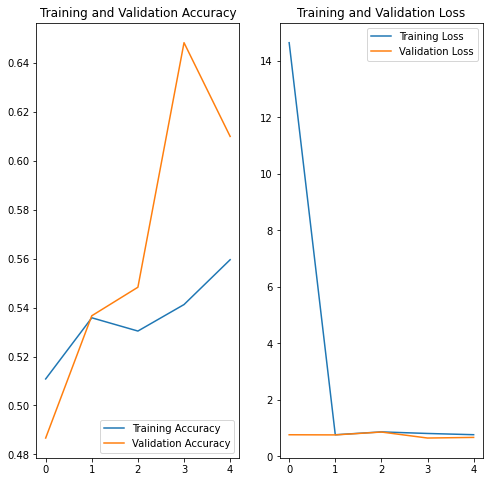

In [39]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=nb_epochs,
  callbacks=[model_checkpoint_callback]
)
show_perfs(history, nb_epochs)

model.load_weights(checkpoint_filepath)

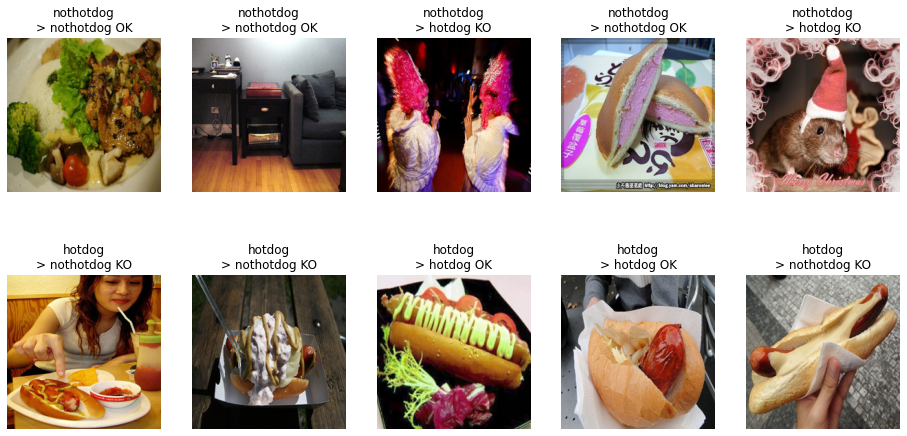


OKs : 5 KOs : 5 Pourcentage OK : 50 %


In [40]:
test_model(model)

On va maintenant essayer d'optimiser les "hyper-paramètres" du modèle.

In [41]:
def model_builder(hp):
    
    # on cherche à optimiser les 2 couches Dense
    hp_units = hp.Int('units', min_value=128, max_value=256, step=32)
    hp_activation_1 = hp.Choice('dense_activation_1',
                                values=['relu', 'tanh', 'sigmoid'],
                                default='relu')
    hp_activation_2 = hp.Choice('dense_activation_2',
                                values=['relu', 'tanh', 'sigmoid'],
                                default='relu')

    # on cherche à optimiser la compilation du modèle
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-5,
                                max_value=1e-2, sampling='LOG', default=1e-3)

    model = tf.keras.models.Sequential([           
      tf.keras.layers.Input(shape=(height, width, 3)),
      data_augmentation,
      tf.keras.layers.Rescaling(1./255),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(hp_units, activation=hp_activation_1),
      tf.keras.layers.Dense(num_classes, activation=hp_activation_2)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])
    
    return model

In [42]:
!pip install -q -U keras-tuner
import keras_tuner as kt
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='keras_tuner',
                     project_name='dogs',
                     overwrite = True)

In [43]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [44]:
img_train = None
label_train = None
for image_batch, labels_batch in tqdm(train_ds):
    if img_train == None:
        img_train = image_batch
        label_train = labels_batch
    else:
        img_train = tf.concat(axis=0, values = [img_train, image_batch])
        label_train = tf.concat(axis=0, values = [label_train, labels_batch])
  
print("img_train:", img_train.shape)
print("label_train:", label_train.shape)

100%|██████████| 75/75 [00:27<00:00,  2.73it/s]

img_train: (2400, 224, 224, 3)
label_train: (2400,)


In [45]:
tuner.search(img_train, label_train, epochs=50, validation_split=0.2, 
             callbacks=[stop_early])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 05m 11s]
val_accuracy: 0.5062500238418579

Best val_accuracy So Far: 0.6458333134651184
Total elapsed time: 01h 02m 37s
INFO:tensorflow:Oracle triggered exit


On récupère les meilleurs hyperparamètres

In [46]:
best_hps.values

{'dense_activation_1': 'relu',
 'dense_activation_2': 'sigmoid',
 'learning_rate': 0.00010414168357719618,
 'tuner/bracket': 0,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/round': 0,
 'units': 160}

In [15]:
model = tf.keras.models.Sequential([           
  tf.keras.layers.Input(shape=(height, width, 3)),
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(160, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00010414168357719618),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 flatten_4 (Flatten)         (None, 150528)            0         
                                                                 
 dense_5 (Dense)             (None, 160)               24084640  
                                                                 
 dense_6 (Dense)             (None, 2)                 322       
                                                                 
Total params: 24,084,962
Trainable params: 24,084,962
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
75/75 [==============================] - 43s 565ms/step - loss: 0.9822 - accuracy: 0.5404 - val_loss: 0.9619 - val_accuracy: 0.5600
Epoch 2/5
75/75 [==============================] - 44s 576ms/step - loss: 1.2160 - accuracy: 0.5317 - val_loss: 0.7217 - val_accuracy: 0.6200
Epoch 3/5
75/75 [==============================] - 42s 559ms/step - loss: 0.9274 - accuracy: 0.5583 - val_loss: 0.8130 - val_accuracy: 0.5900
Epoch 4/5
75/75 [==============================] - 42s 559ms/step - loss: 0.9294 - accuracy: 0.5571 - val_loss: 0.7852 - val_accuracy: 0.6183
Epoch 5/5
75/75 [==============================] - 42s 560ms/step - loss: 0.9686 - accuracy: 0.5487 - val_loss: 1.0347 - val_accuracy: 0.5583


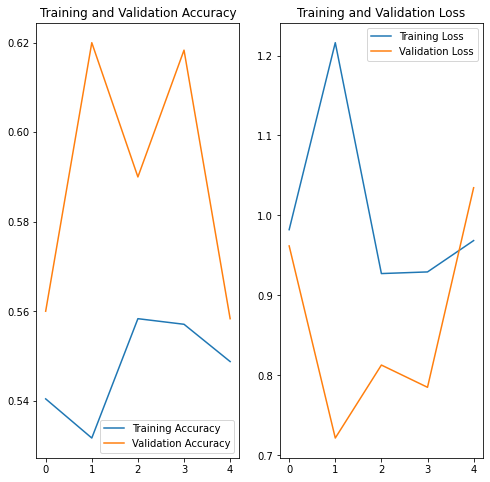

In [18]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=nb_epochs,
  callbacks=[model_checkpoint_callback]
)
show_perfs(history, nb_epochs)

model.load_weights(checkpoint_filepath)

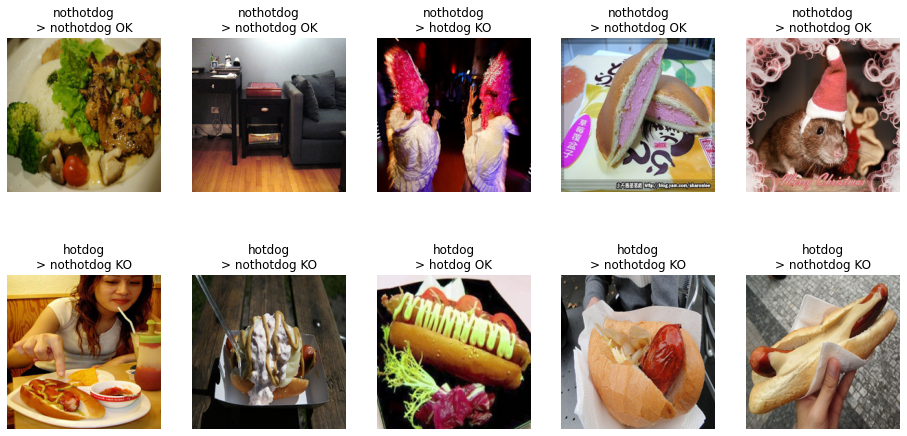


OKs : 5 KOs : 5 Pourcentage OK : 50 %


In [21]:
test_model(model)